In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "../image_dataset/cropped_labeled"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42,
                                             label_mode = 'categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42,
                                             label_mode = 'categorical')

Found 37487 files belonging to 15 classes.
Using 29990 files for training.
Found 37487 files belonging to 15 classes.
Using 7497 files for validation.


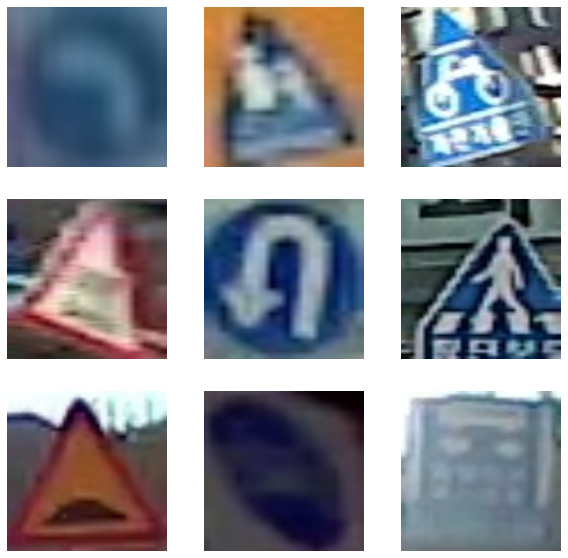

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential([])
    #data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.1))
    ### END CODE HERE
    
    return data_augmentation

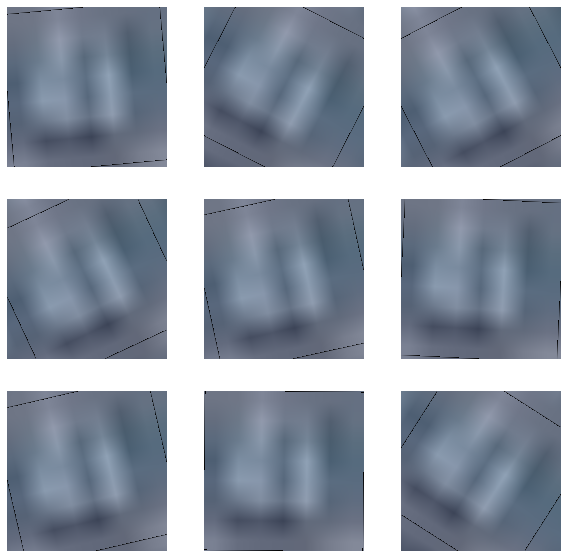

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [10]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [12]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n02074367', 'dugong', 0.1228561), ('n02066245', 'grey_whale', 0.10220283)],
 [('n04152593', 'screen', 0.13574217),
  ('n03843555', 'oil_filter', 0.06724828)],
 [('n04192698', 'shield', 0.43302113), ('n03929660', 'pick', 0.105478376)],
 [('n01930112', 'nematode', 0.07008835), ('n04525038', 'velvet', 0.054575074)],
 [('n02865351', 'bolo_tie', 0.23515832), ('n03840681', 'ocarina', 0.13460913)],
 [('n03843555', 'oil_filter', 0.107259125),
  ('n04591157', 'Windsor_tie', 0.102461584)],
 [('n02488291', 'langur', 0.0436909),
  ('n04591157', 'Windsor_tie', 0.040877707)],
 [('n03347037', 'fire_screen', 0.13691598),
  ('n04372370', 'switch', 0.063222155)],
 [('n02966687', "carpenter's_kit", 0.68525696),
  ('n03995372', 'power_drill', 0.07242154)],
 [('n03825788', 'nipple', 0.29043642), ('n03584829', 'iron', 0.11268925)],
 [('n04525038', 'velvet', 0.20869118),
  ('n03347037', 'fire_screen', 0.076211564)],
 [('n02916936', 'bulletproof_vest', 0.3550962),
  ('n03447721', 'gong', 0.06963524)],
 [(

In [18]:
# UNQ_C2
# GRADED FUNCTION
def traffic_sign_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
  
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    #x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(15,activation='softmax')(x)
    
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [19]:
model2 = traffic_sign_model(IMG_SIZE, data_augmentation)

In [20]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)               

In [22]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
938/938 [==============================] - 257s 274ms/step - loss: 0.7048 - accuracy: 0.7871 - val_loss: 0.4412 - val_accuracy: 0.8626
Epoch 2/5
938/938 [==============================] - 214s 228ms/step - loss: 0.4493 - accuracy: 0.8598 - val_loss: 0.3785 - val_accuracy: 0.8814
Epoch 3/5
938/938 [==============================] - 222s 237ms/step - loss: 0.3958 - accuracy: 0.8765 - val_loss: 0.3666 - val_accuracy: 0.8862
Epoch 4/5
938/938 [==============================] - 222s 237ms/step - loss: 0.3698 - accuracy: 0.8827 - val_loss: 0.3452 - val_accuracy: 0.8928
Epoch 5/5
938/938 [==============================] - 223s 238ms/step - loss: 0.3455 - accuracy: 0.8891 - val_loss: 0.3358 - val_accuracy: 0.8950


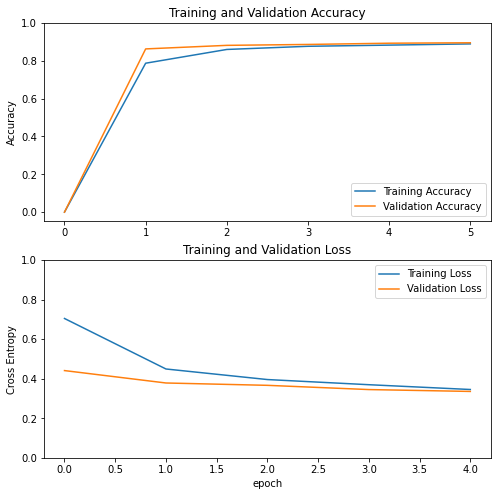

In [23]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
class_names

['101(사거리)',
 '113(S커브)',
 '114(S커브)',
 '129(과속방지턱)',
 '135(공사중)',
 '140(위험)',
 '227(정지)',
 '302(자전거)',
 '306(우회전)',
 '307(좌회전)',
 '311(U턴)',
 '322(횡단보도)',
 '324(어린이보호)',
 '325(자전거)',
 '330(버스전용)']

In [25]:
base_learning_rate = 0.001

In [26]:
# UNQ_C3
base_model = model2.layers[3]
base_model.trainable = True
#take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120


# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr = base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [27]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
938/938 [==============================] - 264s 282ms/step - loss: 0.4077 - accuracy: 0.8713 - val_loss: 0.2510 - val_accuracy: 0.9222
Epoch 6/10
938/938 [==============================] - 264s 281ms/step - loss: 0.2247 - accuracy: 0.9300 - val_loss: 0.2453 - val_accuracy: 0.9309
Epoch 7/10
938/938 [==============================] - 264s 282ms/step - loss: 0.1678 - accuracy: 0.9471 - val_loss: 0.2048 - val_accuracy: 0.9386
Epoch 8/10
938/938 [==============================] - 265s 283ms/step - loss: 0.1405 - accuracy: 0.9578 - val_loss: 0.1964 - val_accuracy: 0.9404
Epoch 9/10
938/938 [==============================] - 273s 291ms/step - loss: 0.1149 - accuracy: 0.9642 - val_loss: 0.1727 - val_accuracy: 0.9506
Epoch 10/10
938/938 [==============================] - 264s 282ms/step - loss: 0.0959 - accuracy: 0.9702 - val_loss: 0.2818 - val_accuracy: 0.9309


In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

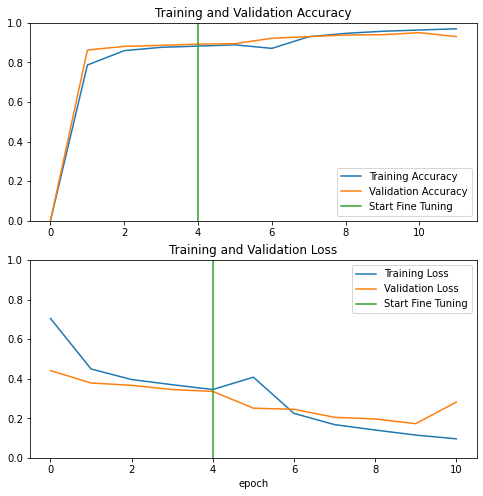

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
import tf2onnx
import onnxruntime as rt

In [31]:
spec = (tf.TensorSpec((None, 299, 299, 3), tf.float32, name="input"),)
output_path = model2.name + ".onnx"

model_proto, _ = tf2onnx.convert.from_keras(model2, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [32]:
model2.save('./mobilev2_newlabeled_model')
model2.save_weights('./mobilev2_newlabeled_weights')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./mobilev2_newlabeled_model\assets


In [33]:
os.system("python -m tf2onnx.convert --saved-model mobilev2_newlabeled_model --output mobilev2_newlabeled.onnx --opset 13")

0

In [36]:
test_directory = '../image_dataset/cropped/image'

In [37]:
test_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42,
                                             label_mode = 'categorical')

Found 37487 files belonging to 15 classes.


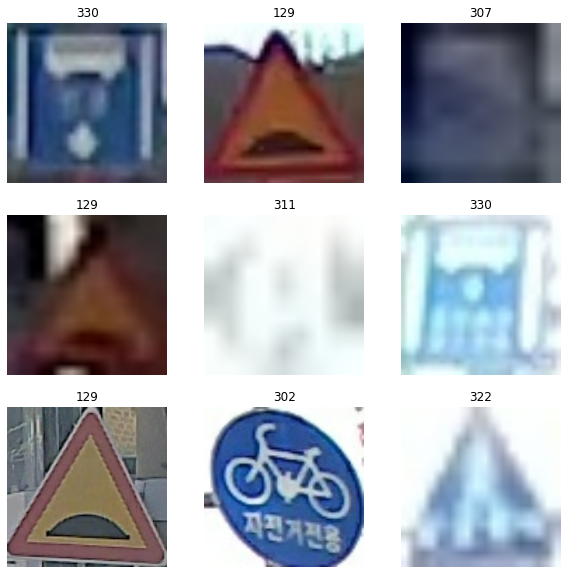

In [57]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        prediction = (model2.predict(images))
        plt.title(class_names[int(np.argmax(prediction[i]))][0:3])
        plt.axis("off")

In [54]:
class_names

['101(사거리)',
 '113(S커브)',
 '114(S커브)',
 '129(과속방지턱)',
 '135(공사중)',
 '140(위험)',
 '227(정지)',
 '302(자전거)',
 '306(우회전)',
 '307(좌회전)',
 '311(U턴)',
 '322(횡단보도)',
 '324(어린이보호)',
 '325(자전거)',
 '330(버스전용)']